In [2]:
from sklearn.cluster import KMeans
from sklearn.metrics import f1_score
from sklearn.metrics import homogeneity_score
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np
import cv2
import glob
from PIL import Image
import regex
from sklearn.cluster import SpectralClustering
import operator
import pandas as pd
import cv2 as cv


# Reading images, extracting groundTruth and boundries 

In [3]:
def read_images():
    image_samples=[]
    boundries=[]
    segmentation_Gt=[]
    images_list=[]
    path= 'BSR/BSDS500/data/images/train/'
    path_mat= 'BSR/BSDS500/data/groundTruth/train/'
    for filename in glob.glob(path+"*.jpg"): 
        im=Image.open(filename) #read file name 
        img = np.array(im) # convert pil to numpy array
        images_list.append(img) 
        image_samples.append(img.reshape(img.shape[0]*img.shape[1], 3)) # reshape to samples 
        image_number=regex.split(r'.jpg',regex.split(r'/', filename)[5])[0] # get the number of the image
        temp= sio.loadmat(path_mat+ image_number) # read groundtruth as a dict
        #Note that each image have diff number of groundtruths, 
        #here we use the first groundtruth of each image temp['groundTruth'][0][0]
        boundries.append(temp['groundTruth'][0][1]['Boundaries'][0][0]) #extract boundries 
        segmentation_Gt.append(temp['groundTruth'][0][1]['Segmentation'][0][0]) #extract ground truth
    return images_list, image_samples, boundries, segmentation_Gt

# utilities

In [4]:
def visualize(img,segmentation_Gt,boundries ,segmentation_pred,i):
    m=plt.figure()
    plt.imshow(img)
    m.savefig("results/img"+str(i)+".png")
              
    s=plt.figure()
    plt.imshow(segmentation_Gt)
    s.savefig("results/segmentation_Gt"+str(i)+".png")
    
    b=plt.figure()
    plt.imshow(boundries)
    b.savefig("results/boundries"+str(i)+".png")
   
    d=plt.figure()
    plt.imshow(segmentation_pred)
    d.savefig("results/segmentation_pred"+str(i)+".png")
    

In [5]:
def evaluate(y_pred, y_true):
    #if (meaure=="F_measure"):
    F_measure_score= f1_score(y_true, y_pred, average=None)
    #else if(measure== "conditional_entropy"):
    conditional_entropy_score= homogeneity_score(y_true, y_pred) 
    #print("F-measure=", F_measure_score, "\n conditional entropy score=",conditional_entropy_score )
    return F_measure_score, conditional_entropy_score

In [6]:
def K_means(X):
    sdict=dict()
    for i in k:
        kmeans = KMeans(n_clusters=i, random_state=0).fit(X)
        sdict[i]=kmeans.labels_
    return sdict

In [7]:
def NN_cut(X,k):
    img = np.array(X)
    res = cv.resize(img,None,fx=.25, fy=.25, interpolation = cv.INTER_CUBIC)
    new_size=res.reshape(res.shape[0]*res.shape[1],3)
    clf=SpectralClustering(n_clusters=k, affinity="nearest_neighbors", n_neighbors=5).fit(new_size)
    return clf.labels_

# Training with K- clusters and get best K

In [8]:
images_list,image_samples, boundries, segmentation_Gt= read_images() #read images


/home/alaasameh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/alaasameh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


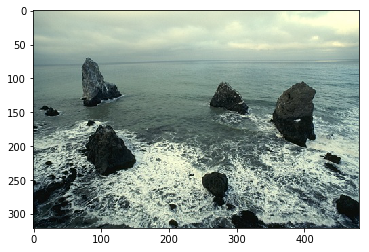

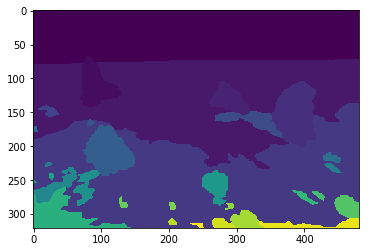

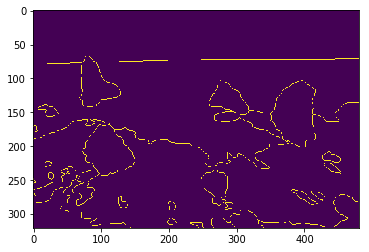

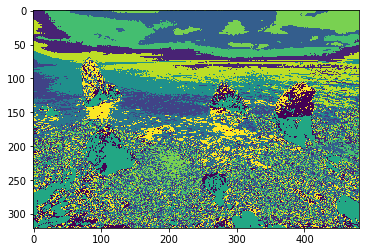

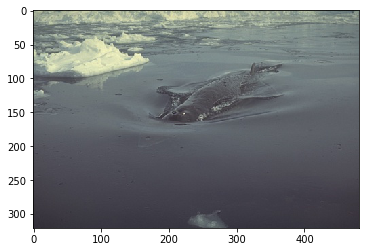

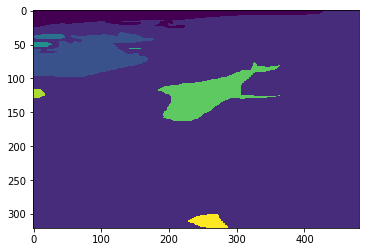

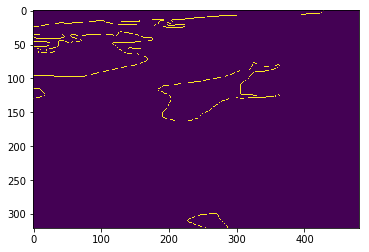

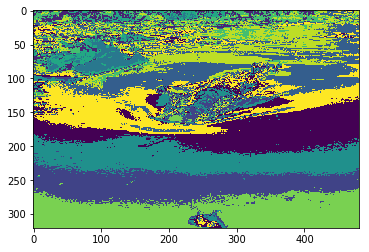

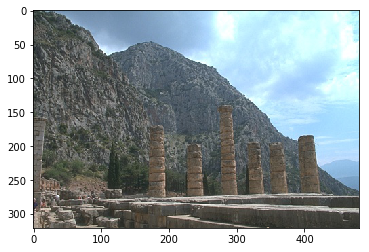

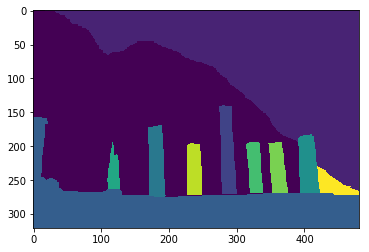

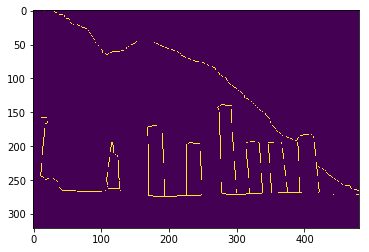

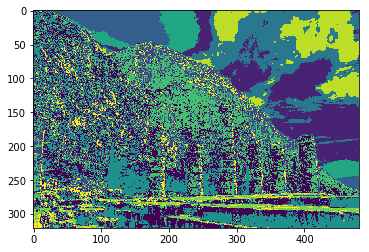

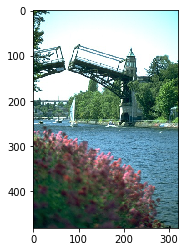

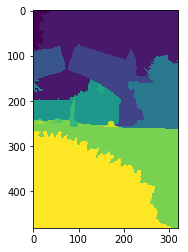

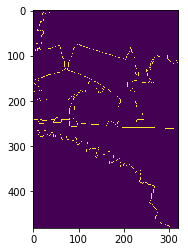

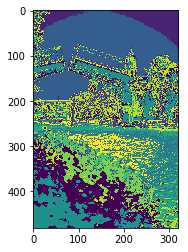

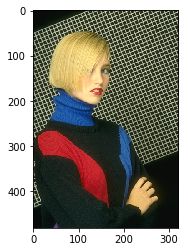

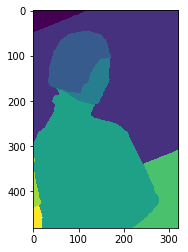

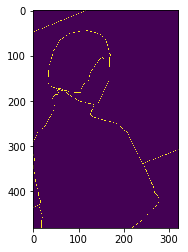

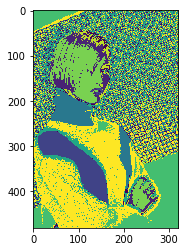

In [18]:
#loop through images and visualize, cluster with kmeans and normalizd_cut 
#and evaluate using F_measure and condtional entropy
k=[3,5,7,9,11]
PicsNum=5
f_measures=np.zeros((PicsNum,len(k)))
entropy_score=np.zeros((PicsNum,len(k)))
segmentation_pred=[]
best_k=[]
listOfDicts=[]
for i in range(PicsNum):
    counter=0
    km=K_means(image_samples[i])
    listOfDicts.append(km)    
    for j in range(3,12,2):
        y_pred=km[j]
        y_true=segmentation_Gt[i].reshape(segmentation_Gt[i].shape[0]*segmentation_Gt[i].shape[1])
        F_measure_score, conditional_entropy_score= evaluate(y_pred, y_true)
        f_measures[i,counter]=np.sum(F_measure_score)/j
        entropy_score[i,counter]=np.sum(conditional_entropy_score)
        counter+=1
    t=np.argmax(entropy_score[i])
    best_k.append((t+2)*2-1)
    segmentation_pred.append(np.asarray(km[best_k[i]]).reshape(segmentation_Gt[i].shape[0],segmentation_Gt[i].shape[1]))
    visualize(images_list[i],segmentation_Gt[i],boundries[i],segmentation_pred[i],i)

In [19]:
f_measures_pd= pd.DataFrame(data=f_measures, columns=[3,5,7,9,11]) 
entropy_score_pd= pd.DataFrame(data=entropy_score, columns=[3,5,7,9,11]) 

In [20]:
f_measures_pd

,3,5,7,9,11
0,0.267529,0.005116,0.121805,0.029682,0.027109
1,0.014582,0.265130,0.004602,0.114521,0.064404
2,0.058828,0.033598,0.038966,0.043617,0.003562
3,0.005637,0.024312,0.027470,0.105899,0.049512
4,0.097272,0.096431,0.030997,0.036077,0.001871


In [21]:
entropy_score_pd

,3,5,7,9,11
0,0.253872,0.297085,0.313597,0.319402,0.325203
1,0.311555,0.333457,0.365775,0.375962,0.377991
2,0.347436,0.425950,0.432707,0.475116,0.481944
3,0.341193,0.369287,0.414040,0.436115,0.481097
4,0.158731,0.250734,0.354292,0.444896,0.514390


In [22]:
#based of conditional entropy=
for i in range (5):
    print("for image", i, "best k=",best_k[i])

for image 0 best k= 11
for image 1 best k= 11
for image 2 best k= 11
for image 3 best k= 11
for image 4 best k= 11


# NN-Cut

/home/alaasameh/anaconda3/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/alaasameh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/alaasameh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


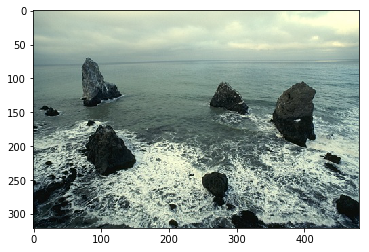

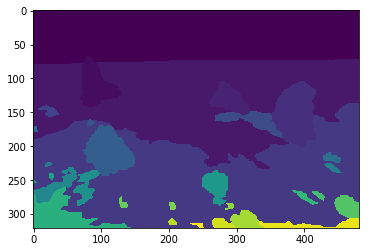

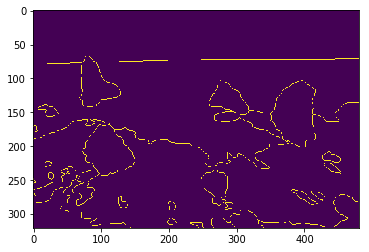

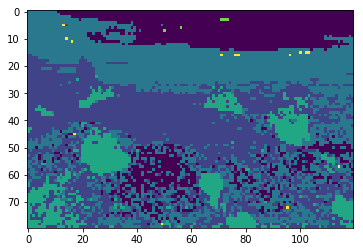

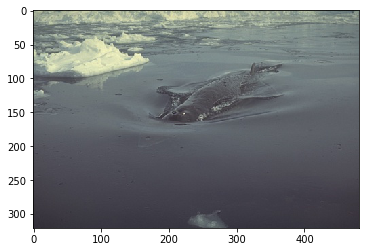

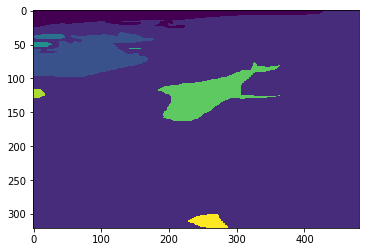

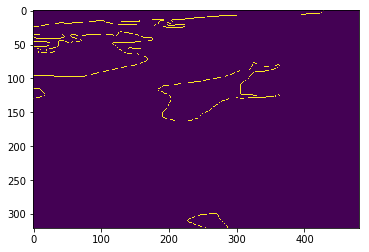

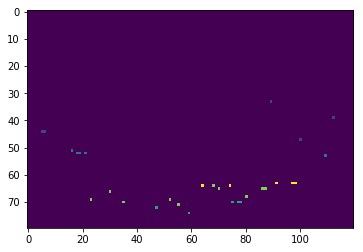

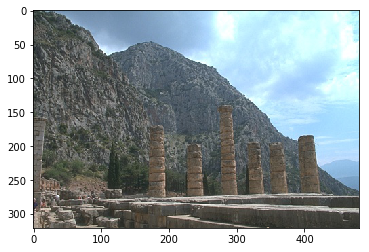

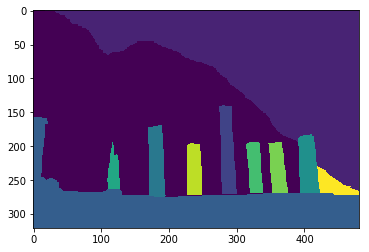

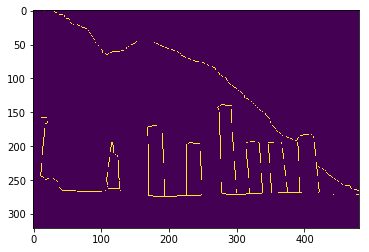

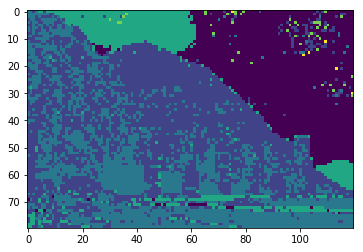

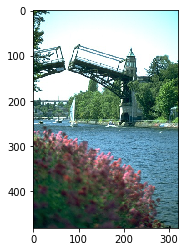

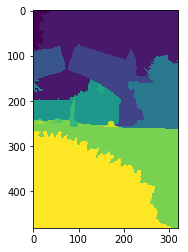

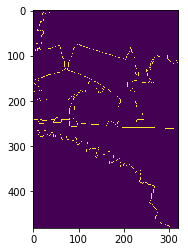

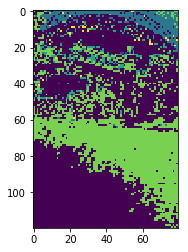

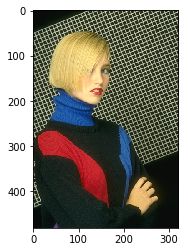

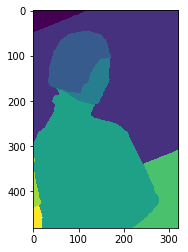

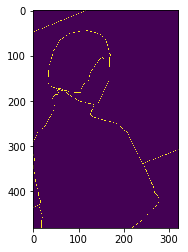

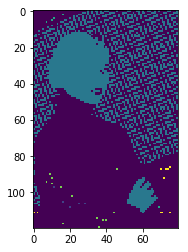

In [14]:
PicsNum=5
k=5
NN_f_measures=[]
NN_entropy_score=[]
NN_segmentation_pred=[]
for i in range(PicsNum):
    NN_y_pred=NN_cut(images_list[i], 6)
    resize_GT = cv.resize(segmentation_Gt[i],None,fx=.25, fy=.25, interpolation = cv.INTER_CUBIC)
    NN_y_true=resize_GT.reshape(resize_GT.shape[0]*resize_GT.shape[1])
    NN_F_measure_score, NN_conditional_entropy_score= evaluate(NN_y_pred, NN_y_true)
    NN_f_measures.append(np.sum(NN_F_measure_score)/k)
    NN_entropy_score.append(np.sum(NN_conditional_entropy_score))
    NN_segmentation_pred.append(NN_y_pred.reshape(resize_GT.shape[0],resize_GT.shape[1]))
    visualize(images_list[i],segmentation_Gt[i],boundries[i],NN_segmentation_pred[i],i)   


In [15]:
NN_f_measures_pd= pd.DataFrame(data=NN_f_measures, columns=[5]) 
NN_entropy_score_pd= pd.DataFrame(data=NN_entropy_score, columns=[5]) 

In [16]:
NN_f_measures_pd

,5
0,0.004233
1,0.000242
2,0.136374
3,0.096469
4,0.095182


In [17]:
NN_entropy_score_pd

,5
0,0.240533
1,0.000773
2,0.361357
3,0.168906
4,0.163103


# Testing

In [ ]:
KMeans(n_clusters=5, random_state=0).fit_predict(image_samples[100])
visualize(images_list[100],segmentation_Gt[100],boundries[100])

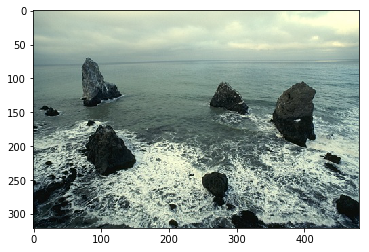

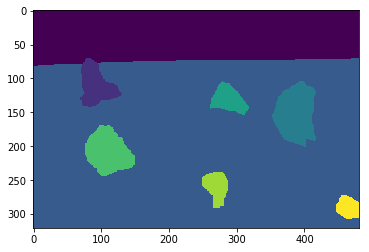

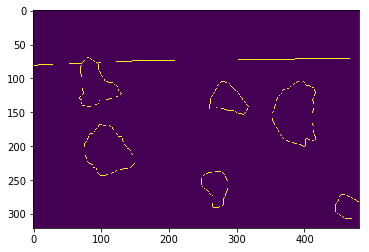

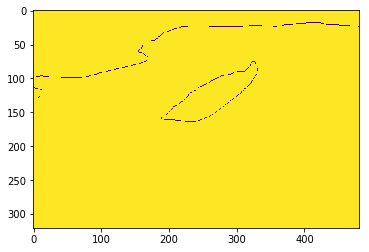

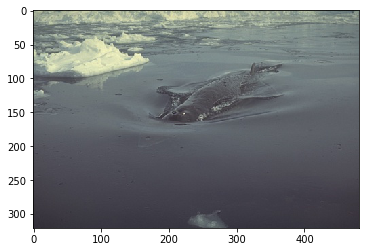

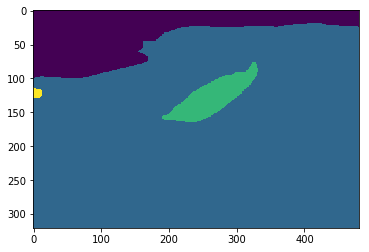

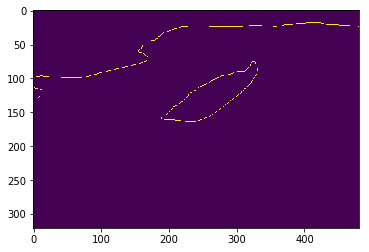

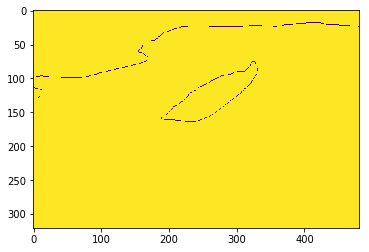

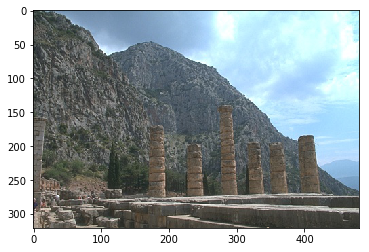

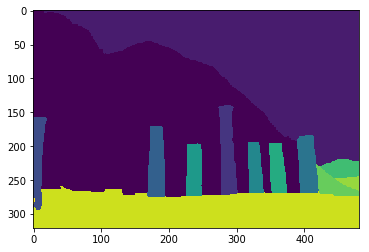

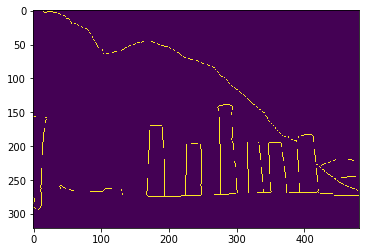

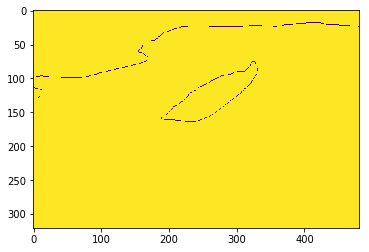

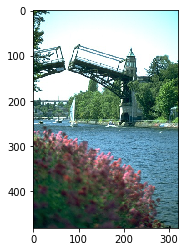

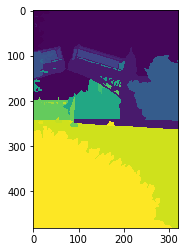

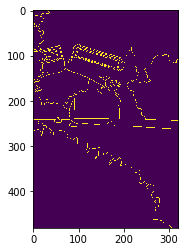

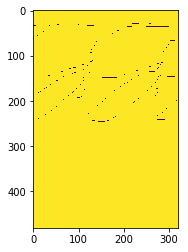

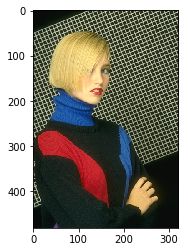

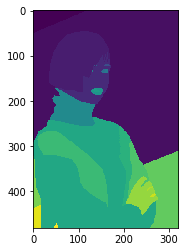

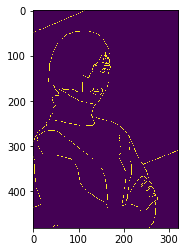

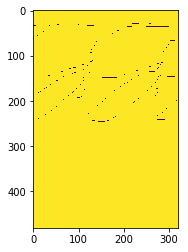

In [64]:
#loop through images and visualize, cluster with kmeans and normalizd_cut 
#and evaluate using F_measure and condtional entropy
PicsNum=5
f_measures=np.zeros((PicsNum,len(k)))
entropy_score=np.zeros((PicsNum,len(k)))
segmentation_pred=[]
best_k=[]
listOfDicts=[]
seg_pred=[]
for i in range(PicsNum):
    kmeans = KMeans(n_clusters=5, random_state=0).fit(boundries[1].reshape(boundries[1].shape[0]*boundries[1].shape[1]).reshape(-1, 1))
    segmentation_pred.append(kmeans.labels_)
    y_true=segmentation_Gt[i].reshape(segmentation_Gt[i].shape[0]*segmentation_Gt[i].shape[1])
    seg_pred.append(segmentation_pred[i].reshape(boundries[i].shape[0],boundries[i].shape[1]))
    
    visualize(images_list[i],segmentation_Gt[i],boundries[i],seg_pred[i],i)